<a href="https://colab.research.google.com/github/MdAbuRummanRefat/RealTimeEmotion-GenderClassification/blob/main/EmotionClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data=pd.read_csv('/content/drive/My Drive/Project/fer2013.csv')
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
labels = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(labels)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Digust,547


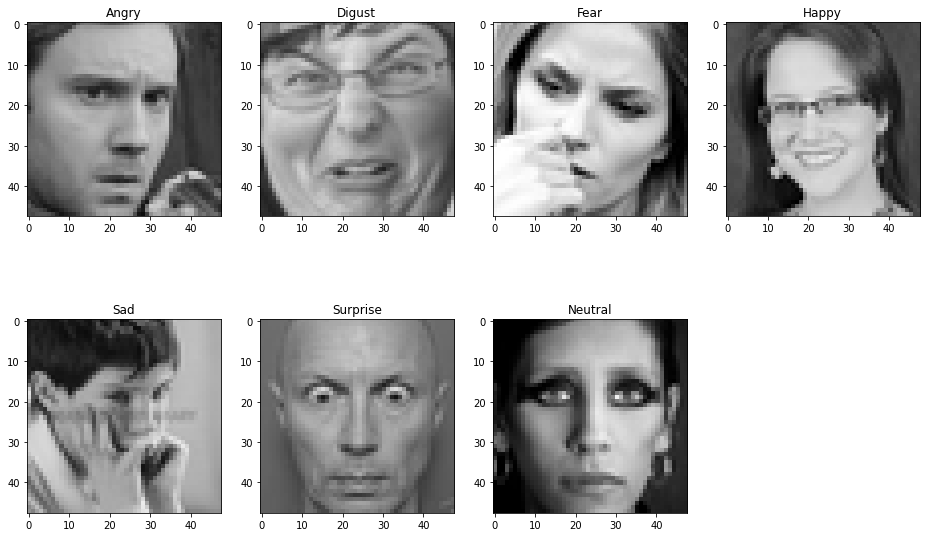

In [ ]:
def row2image(row):
    pixels, emotion = row['pixels'], labels[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

In [ ]:
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()

In [ ]:
from keras.utils import to_categorical
def pre_Processing(data):
    temp = data.pixels.apply(lambda row: [float(p) for p in row.split()])
    X = np.array(temp.tolist())
    X = X.reshape(-1,48,48,1)
    X = X/255.0
    Y = to_categorical(data['emotion'], len(labels)) 
    return X,Y

X_train,y_train = pre_Processing(data_train)
X_test,y_test = pre_Processing(data_test)
X_val,y_val = pre_Processing(data_val)

In [ ]:
X_train=X_train/255.0
X_val=X_val/255.0
X_test=X_test/255.0
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(X_test))

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


In [ ]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2

In [ ]:
def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               # kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model

In [ ]:
# parameters
batch_size = 32
num_epochs = 110
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50

In [ ]:
# model parameters/compilation
model = mini_XCEPTION(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [ ]:

from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(patience/4), verbose=1)

In [ ]:
model.fit(data_generator.flow(X_train, y_train,batch_size),
                        steps_per_epoch=len(X_train) // batch_size,
                        epochs=num_epochs, verbose=1, callbacks=[reduce_lr],
                        validation_data=(X_val,y_val))

Epoch 1/110
897/897 [==============================] - 18s 20ms/step - loss: 1.7804 - accuracy: 0.3246 - val_loss: 1.8490 - val_accuracy: 0.3767
Epoch 2/110
897/897 [==============================] - 18s 20ms/step - loss: 1.5148 - accuracy: 0.4310 - val_loss: 1.6323 - val_accuracy: 0.4199
Epoch 3/110
897/897 [==============================] - 18s 20ms/step - loss: 1.3895 - accuracy: 0.4761 - val_loss: 1.3795 - val_accuracy: 0.4851
Epoch 4/110
897/897 [==============================] - 18s 20ms/step - loss: 1.3245 - accuracy: 0.4987 - val_loss: 1.4676 - val_accuracy: 0.4461
Epoch 5/110
897/897 [==============================] - 18s 20ms/step - loss: 1.2745 - accuracy: 0.5196 - val_loss: 1.3792 - val_accuracy: 0.4762
Epoch 6/110
897/897 [==============================] - 18s 20ms/step - loss: 1.2430 - accuracy: 0.5321 - val_loss: 1.4344 - val_accuracy: 0.4854
Epoch 7/110
897/897 [==============================] - 18s 20ms/step - loss: 1.2159 - accuracy: 0.5407 - val_loss: 1.2519 - val_ac

In [ ]:
model.evaluate(X_test,y_test)

113/113 [==============================] - 0s 3ms/step - loss: 0.9727 - accuracy: 0.6431


[0.9726652503013611, 0.6430760622024536]

In [ ]:
model.save('/content/drive/My Drive/Project/Emotion_mini_XCEPTION.102-0.66.hdf5')